In [1]:
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import funciones 
from collections import Counter



In [2]:
datos = pd.read_csv('./Input/GSAF5.csv', encoding = 'ISO-8859-1')

In [3]:
#En primer lugar realizo un analisis de los datos para conocer de que manera puedo y debo trabajar con ellos.

print(datos.dtypes)

Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object


In [4]:
print(datos.shape)


(5992, 24)


In [5]:
datos.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [6]:
missing_values_count = datos.isnull().sum()
print(missing_values_count)

Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


In [7]:
"""En el analisis he podido observar que hay columnas vacias, columnas repetidas, y columnas que 
no voy a utilizar para ningun analisis, por lo que considero que es mejor
eliminarlas para dejar la tabla mas limpia y facil de visualizar."""

"""#Despues de ver los datos utiles que se pueden limpiar he decidido responder la pregunta de:
¿En que mes del año hay mas ataques de tiburon a personas que practican un deporte con tabla?, dividido por muertos y heridos.
"""

dt = datos.drop(columns=["Unnamed: 22","Unnamed: 23","href formula","Case Number.1","Time","pdf","href","original order", "Investigator or Source","Case Number.2","Case Number","Age","Species "])

In [8]:
dt.columns

Index(['Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity',
       'Name', 'Sex ', 'Injury', 'Fatal (Y/N)'],
      dtype='object')

In [9]:
print(dt.shape)


(5992, 11)


In [10]:
dt['Year'].value_counts()

  

2015    139
2011    128
2014    125
0       124
2013    122
       ... 
1742      1
1758      1
1818      1
1822      1
1595      1
Name: Year, Length: 232, dtype: int64

In [11]:
"""Ahora que tengo las columnas con las que quiero trabajar voy a limpiar las filas /
empezando por quitar todos aquellos datos que sean de antes del 1600, considero que podrian no ser demasiado fiables."""


dt["Year"] = dt["Year"].apply(funciones.clean_year)

In [12]:
"""Voy a eliminar todas las filas que tengan NaN en "Year" o "Activity", ya que el year me aporta la fiabilidad
y voy a responder mi hipotesis relacioanada con las actividades"""

'Voy a eliminar todas las filas que tengan NaN en "Year" o "Activity", ya que el year me aporta la fiabilidad\ny voy a responder mi hipotesis relacioanada con las actividades'

In [13]:
dt.dropna(how='any', subset=['Year','Activity',], inplace=True)


In [14]:
"""Voy a crear una distribucion por meses para poder distribuir los datos de una forma mas especifica"""
# He intentado meterlo en una funcion pero me daba problemas continuamente. La funcion esta en el archivo "funciones"

meses = []
for fila in dt['Date']:
    
    mes_fila = ''.join(re.findall('\-[A-Za-z]{3}\-',fila))
    
    mes_fila = re.sub('\-','', mes_fila).capitalize()
        
        
    if mes_fila == '':
        mes_fila = np.nan

    meses.append(mes_fila)

print(meses)    
    
dt['Month'] = meses

['Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep'

In [15]:
dt["Month"].value_counts()

Jul       539
Aug       496
Sep       461
Jan       441
Jun       426
Oct       368
Dec       358
Apr       343
Mar       341
Nov       334
May       317
Feb       314
Marmar      2
Sepsep      1
Augaug      1
Jut         1
Novnov      1
Janjan      1
Name: Month, dtype: int64

In [16]:
n_month = dt["Month"].isnull().sum()
print(n_month)

610


In [17]:
dt.dropna(how='any', subset=['Month'], inplace=True)

In [18]:
dt["Month"] = dt["Month"].astype(str)

In [19]:
#Con esta tambien me pasa, he metido la funcion en Funciones pero me devuelve que todos los valores son "None"

for i in dt["Month"]:
        if len(i) > 3:
            dt["Month"].replace(i,i[:3], inplace=True)
        if i == "Jut":
            dt["Month"].replace(i,'Jun', inplace=True)

In [20]:
dt["Month"].value_counts()

Jul    539
Aug    497
Sep    462
Jan    442
Jun    427
Oct    368
Dec    358
Mar    343
Apr    343
Nov    335
May    317
Feb    314
Name: Month, dtype: int64

In [21]:
#Aqui realizo un cambio de la columna "Month" para que siga a la de años.
dt= funciones.cha_col_pos("Month",2,dt)
dt


,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N)
0,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
5,15-Sep-16,2016.0,Sep,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,Minor injury to arm,N
7,07-Sep-16,2016.0,Sep,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016.0,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016.0,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,Lacerations & punctures to lower right leg,N


In [22]:
dt["Year"] = dt["Year"].astype(int)

In [23]:
#Renombre de las columna Fatal y analisis para realizar su limpieza y simplificación.

dt = dt.rename(columns={"Fatal (Y/N)" : "Fatal"})

In [24]:
ms = dt["Fatal"].isnull().sum()
print(ms)

11


In [25]:
dt["Fatal"].value_counts()

N          3559
Y          1142
UNKNOWN      27
 N            5
n             1
Name: Fatal, dtype: int64

In [26]:
dt["Fatal"] = dt["Fatal"].astype(str)

In [27]:
dt["Fatal"] = dt["Fatal"].apply(funciones.fatal_cl)

In [28]:
dt.dropna(how='any', subset=['Fatal'], inplace=True)

In [29]:
dt.shape

(4701, 12)

In [30]:
dt["Activity"].value_counts()

Surfing                                                                     865
Swimming                                                                    731
Fishing                                                                     352
Spearfishing                                                                252
Wading                                                                      131
                                                                           ... 
Went to aid of child being menaced by the shark                               1
Retrieving bait box that had fallen overboard                                 1
Spearfishing / night diving                                                   1
Catching a turtle                                                             1
Spearfishing, free diving, possibly ascended into path of cruising shark      1
Name: Activity, Length: 1224, dtype: int64

In [31]:
#Con esta tambien me pasa, no se como trabajarla como funcion.


"""#Con esto voy a sacar todos los deportes que se realicen con una tabla de la lista de actividades
para sacar un nuevo DataFrame y trabajar con el"""

act = []
for fila in dt['Activity']:
    
    act_fila = ''.join(re.findall(('Surfing|surfing|Surf|surf|Board|board'),fila))
    
    act_fila = re.sub('\-','', act_fila).capitalize()
        
        
    if act_fila == '':
        act_fila = np.nan

    act.append(act_fila)

print(act) 

dt['Activity'] = act     

['Surfing', 'Surfing', 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', 'Board', 'Surfing', 'Board', nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, nan, nan, nan, nan, nan, 'Surfing', nan, nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', 'Surfing', nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surf', nan, nan, nan, nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', nan, 'Surfing', nan, 'Surfing', 'Surfing', nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, nan, 'Surfing', nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, nan, 'Board', 'Surfing', 'Surfing', 'Surfing', nan, 'Surfing', nan, nan, 'Board', 'Surfing', nan, 'Surfing', 'Board', nan, 'Surfing', 'Surfing', nan, nan, 'Surfing', nan, nan, nan, nan, 'Su

In [32]:
dt["Activity"] = dt["Activity"].astype(str)
dt['Activity'] = act 

In [33]:
dt["Activity"].value_counts()

Surfing              979
Board                239
Surf                  94
Surfboard             25
Surfingboard          19
Surfingsurfboard       4
Boardboard             3
Boardsurf              2
Boardsurfing           2
Surfingsurfing         1
Surfingboardboard      1
Surfboardboard         1
Name: Activity, dtype: int64

In [34]:
ms = dt["Activity"].isnull().sum()
print(ms)

3331


In [35]:
dt.dropna(how='any', subset=['Activity'], inplace=True)

In [36]:
for i in dt["Activity"]:
    dt["Activity"].replace(i,"Board Sport", inplace=True)
    

In [37]:
dt["Fatal"].value_counts()

N    1210
Y     160
Name: Fatal, dtype: int64

In [38]:
"""Por ultimo organizo los datos en listas para poder meterlos en un grafico que separe los ataques
por Fatal y Not Fatal distribuidos en los meses del año."""


dt_nofatal = dt[dt["Fatal"]=="N"]
dt_fatal = dt[dt["Fatal"]=="Y"]

In [39]:
list_month_n = Counter(dt_nofatal["Month"].tolist()).most_common(12)
list_month_y = Counter(dt_fatal["Month"].tolist()).most_common(12)

In [40]:
print(list_month_n)
print(list_month_y)

[('Oct', 152), ('Sep', 141), ('Aug', 126), ('Jul', 124), ('Apr', 99), ('Mar', 96), ('Jun', 94), ('Nov', 90), ('Jan', 82), ('May', 74), ('Feb', 66), ('Dec', 66)]
[('Dec', 19), ('Jan', 18), ('Sep', 17), ('Jun', 15), ('Apr', 14), ('Aug', 14), ('May', 12), ('Oct', 12), ('Jul', 11), ('Nov', 10), ('Mar', 10), ('Feb', 8)]


In [41]:
list_month_y.insert(0, list_month_y.pop(7))
list_month_y.insert(1, list_month_y.pop(3))
list_month_y.insert(2, list_month_y.pop(6))
list_month_y.insert(3, list_month_y.pop(8))
list_month_y.insert(4, list_month_y.pop(7)) 
list_month_y.insert(5, list_month_y.pop(9))
list_month_y.insert(6, list_month_y.pop(8))
list_month_y.insert(7, list_month_y.pop(10))
list_month_y.insert(8, list_month_y.pop(9))
list_month_y.insert(9, list_month_y.pop(10))

In [42]:
list_month_y.insert(10, list_month_y.pop(11))

In [43]:
month = [i[0] for i in list_month_n]
n = [i[1] for i in list_month_n]
y = [i[1] for i in list_month_y]

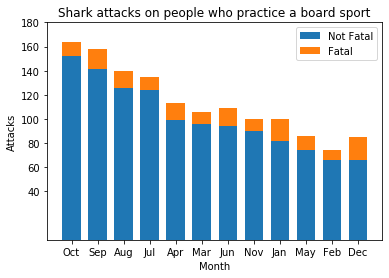

'El el grafico puede observarse que octubre es el mes con mas ataques de tiburon a personas que practican con tabla\ny diciembre el mes con menos ataques, seguramente a causa del clima.\nEl mes con más muertes es diciembre y el mes con menos es febrero.\n\nComo conclusión final puede observarse que, siendo diciembre el mes en el que menos ataques hay, seguramente\ntambién a causa de que hay menos surfistas por el clima, es el mes en el que los tiburones son mas agresivos.\n¡Nota mental: No hacer deportes con tabla en diciembre!'

In [44]:
N = 12
ind = np.arange(N)  
width = 0.70      

p1 = plt.bar(ind, n, width)
p2 = plt.bar(ind, y, width, bottom=n)


plt.ylabel('Attacks')
plt.xlabel('Month')
plt.title('Shark attacks on people who practice a board sport')
plt.xticks(ind,('Oct',
 'Sep',
 'Aug',
 'Jul',
 'Apr',
 'Mar',
 'Jun',
 'Nov',
 'Jan',
 'May',
 'Feb',
 'Dec'))
plt.yticks(np.arange(40, 190, 20))
plt.legend((p1[0], p2[0]), ('Not Fatal', 'Fatal'))

plt.show()

"""El el grafico puede observarse que octubre es el mes con mas ataques de tiburon a personas que practican con tabla
y diciembre el mes con menos ataques, seguramente a causa del clima.
El mes con más muertes es diciembre y el mes con menos es febrero.

Como conclusión final puede observarse que, siendo diciembre el mes en el que menos ataques hay, seguramente
también a causa de que hay menos surfistas por el clima, es el mes en el que los tiburones son mas agresivos.
¡Nota mental: No hacer deportes con tabla en diciembre!"""

In [45]:
export_csv = dt.to_csv (r'./output/export_dataframe.csv', index = None, header=True)
